In [1]:
if(!requireNamespace("BiocManager")) install.packages("BiocManager")

Loading required namespace: BiocManager


In [2]:
lib.list=c("Seurat","plyr","ggpubr","dplyr","ggthemes","data.table","GSVA","biomaRt")

for(i in 1:length(lib.list)){
	if(any(installed.packages()[,1]==lib.list[i])){
		library(lib.list[i],character.only=T)}else{
			BiocManager::install(lib.list[i])
			library(lib.list[i],character.only=T)
    };
}

Loading required package: ggplot2
Loading required package: cowplot
Warning message:
“package ‘cowplot’ was built under R version 3.5.2”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix
Loading required package: magrittr

Attaching package: ‘ggpubr’

The following object is masked from ‘package:plyr’:

    mutate

The following object is masked from ‘package:cowplot’:

    get_legend

Warning message:
“package ‘dplyr’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘ggthemes’ was built under R version 3.5.2”
Attaching package: ‘ggthemes’

The following object is mask

In [3]:
source("~/Research/scripts/r_scripts/useful_functions.R")
source("~/Research/scripts/r_scripts/plotfns.R")

Until now, all the required packages and R functions are loaded. Our next step includes reading all the individual tumor datasets using "Seurat" R package and follow their primary analysis workflow, which includes filtering, normalization, scaling (while regressing out any known technical variables) and identifying variable genes.

In [4]:
## Read the list of mouse genesets
ach = read.gmt.file("~/Research/pathways/mouse_pathways/acharya_genesets_mouse.gmt")

Number of genesets read:  50 


In [5]:
ach$geneset.names

[1] "CP_INHIBITORY"                     "CP_STIMULATORY"                   
 [3] "TCELL_ACTIVATION"                  "TCELL_CYTOLYTIC_ACT"              
 [5] "MACROPHAGE_ACTIVITY"               "NK_CELLS"                         
 [7] "LCK"                               "Tfh"                              
 [9] "Treg"                              "MHC_I"                            
[11] "MHC_II"                            "STAT1"                            
[13] "B_CELLS"                           "NEUTROPHILS"                      
[15] "DENDRITIC_CELLS"                   "INFLAMMATORY RESPONSE"            
[17] "EMT"                               "WNT BETA CATENIN SIGNALING"       
[19] "TGF BETA SIGNALING"                "G2M CHECKPOINT"                   
[21] "APOPTOSIS"                         "NOTCH SIGNALING"                  
[23] "ESTROGEN RESPONSE EARLY"           "ESTROGEN RESPONSE LATE"           
[25] "HEDGEHOG SIGNALING"                "PI3K-AKT-MTOR SIGNALING"          
[27] "MTORC1 SIGNALING"                  "E2F TARGETS"                      
[29] "MYC TARGETS"                       "P53 PATHWAY"                      
[31] "KRAS SIGNALING UP"                 "HYPOXIA"                          
[33] "INVASIVENESS GENE SIGNATURE"       "EPIGENETIC STEM CELL"             
[35] "ANGIOGENESIS"                      "ECM"                              
[37] "INTERFERON ALPHA RESPONSE"         "INTERFERON GAMMA RESPONSE"        
[39] "FIBROBLAST GROWTH FACTOR RECEPTOR" "CHROMOSOMAL INSTABILITY"          
[41] "BASE EXCISION REPAIR"              "MISMATCH EXCISION REPAIR"         
[43] "NUCLEOTIDE EXCISION REPAIR"        "HOMOLOGOUS RECOMBINATION"         
[45] "NONHOMOLOGOUS END JOINING"         "LUMINAL PROGENITORS"              
[47] "STROMAL"                           "MASC"                             
[49] "LUMINAL"                           "BASAL"

Let's add PAM50 genes to this list. Since, this gene-list includes human genes, we will have to convert them into their mouse homologs.

In [6]:
pam50 = scan("~/Research/pathways/pam50_genes.txt",what="")
pam50_mm = convertHumanGeneList(pam50)

Let's add these genes to the "ach" list object.

In [7]:
ach$geneset.descriptions[51]="PAM50_mouse_homologs"
ach$geneset.names[51]="PAM50"
ach$genesets[[51]]=pam50_mm
names(ach$genesets)[51]="PAM50"

Read all the .tsv files and load the as "Seurat" objects.

In [8]:
files = list.files(pattern=".tsv")
files = files[files %in% c("MT1.tsv","TU1.tsv","TU2.tsv","TU3.tsv","TU4.tsv")]
data_list = llply(1:length(files),.progress="time",function(i) read.delim(files[i],header=T,row.names=1))


|====================================================|100%                      Completed after 31 s 


In [10]:
seu_list = gene_list = vector(mode="list",length=length(data_list))
for(i in 1:length(seu_list)){
  print(i)
  seu = CreateSeuratObject(raw.data=data_list[[i]],min.cells=5)
  seu@meta.data$group = gsub(".tsv","",files[i])
  seu = FilterCells(seu, subset.names = "nGene", low.thresholds = round(quantile(seu@meta.data$nGene,0.1)), high.thresholds = Inf)
  seu = NormalizeData(seu,display.progress = F)
  seu = ScaleData(seu, display.progress = F,vars.to.regress = c("nUMI"))
  seu = FindVariableGenes(seu,display.progress = F, do.plot = F, mean.function = ExpMean, dispersion.function = LogVMR)
  genes_use = head(rownames(seu@hvg.info), 2000)
  seu_list[[i]] = seu
  gene_list[[i]] = genes_use
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


We run the multi-CCA pipeline that "Seurat" most recently published. 

In [11]:
cca_out = RunMultiCCA(seu_list,genes.use=Reduce("intersect",gene_list),num.ccs = 20)

[1] "Computing CC 1"
[1] "Computing CC 2"
[1] "Computing CC 3"
[1] "Computing CC 4"
[1] "Computing CC 5"
[1] "Computing CC 6"
[1] "Computing CC 7"
[1] "Computing CC 8"
[1] "Computing CC 9"
[1] "Computing CC 10"
[1] "Computing CC 11"
[1] "Computing CC 12"
[1] "Computing CC 13"
[1] "Computing CC 14"
[1] "Computing CC 15"
[1] "Computing CC 16"
[1] "Computing CC 17"
[1] "Computing CC 18"
[1] "Computing CC 19"
[1] "Computing CC 20"


Scaling data matrix


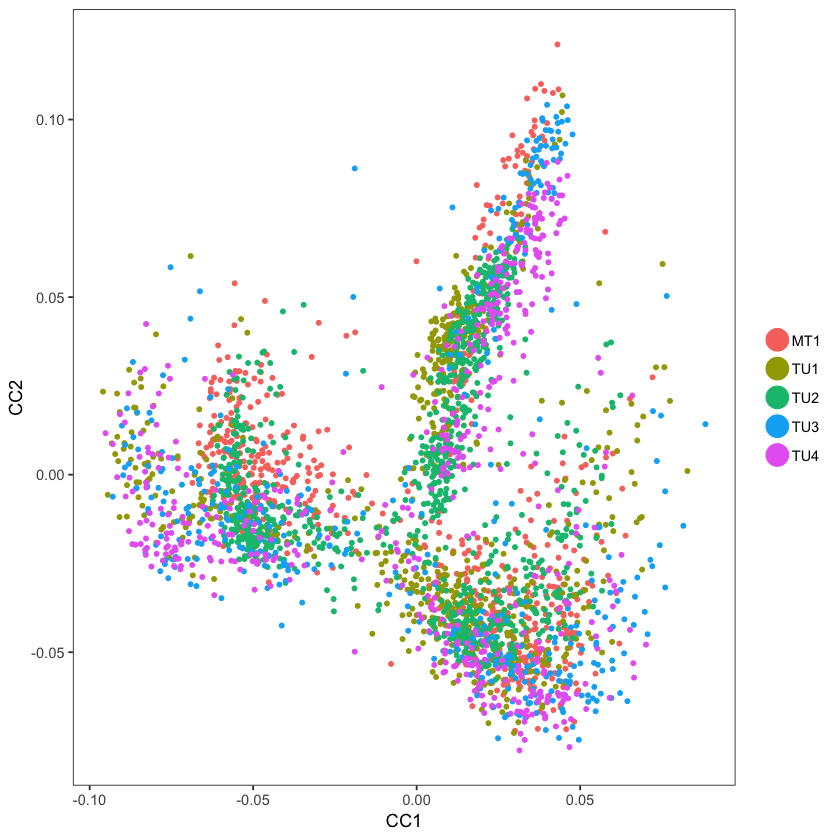

In [12]:
DimPlot(object = cca_out, reduction.use = "cca", group.by = "group", pt.size = 1, do.return = F)

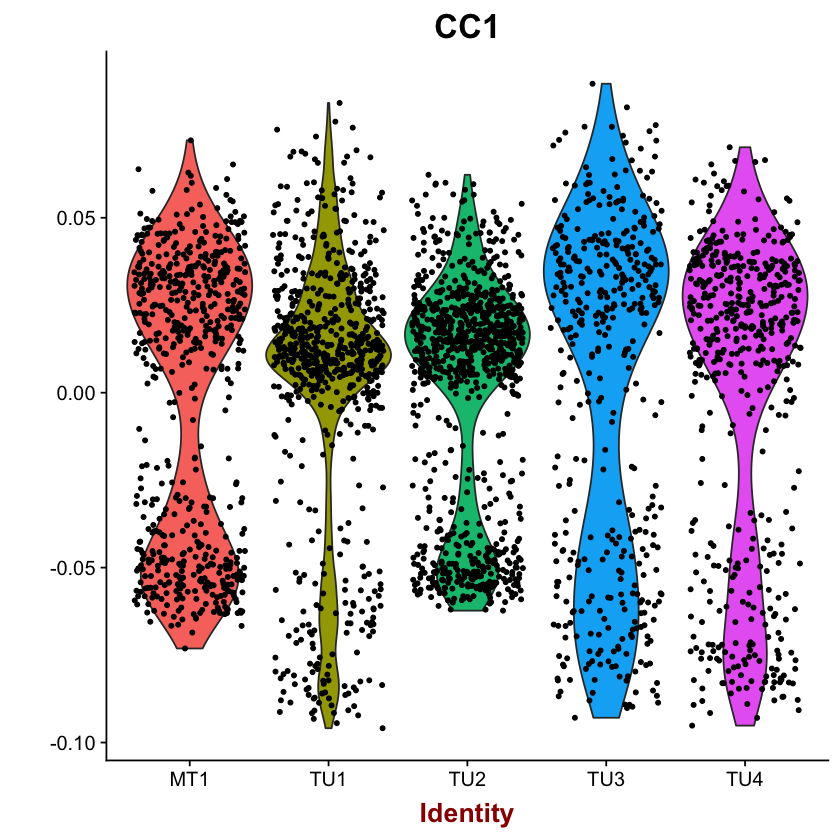

In [13]:
VlnPlot(object = cca_out, features.plot = "CC1", group.by = "group", do.return = F)

We now look at the biweight midcorrelation (bicor) of the 30th gene ranked by minimum bicor across the specified CCs for each tumor dataset. "bicor" is a median-based similarity metric (robust to outliers). We visualize the number of CCs to proceed with in the Seurat alignment workflow.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


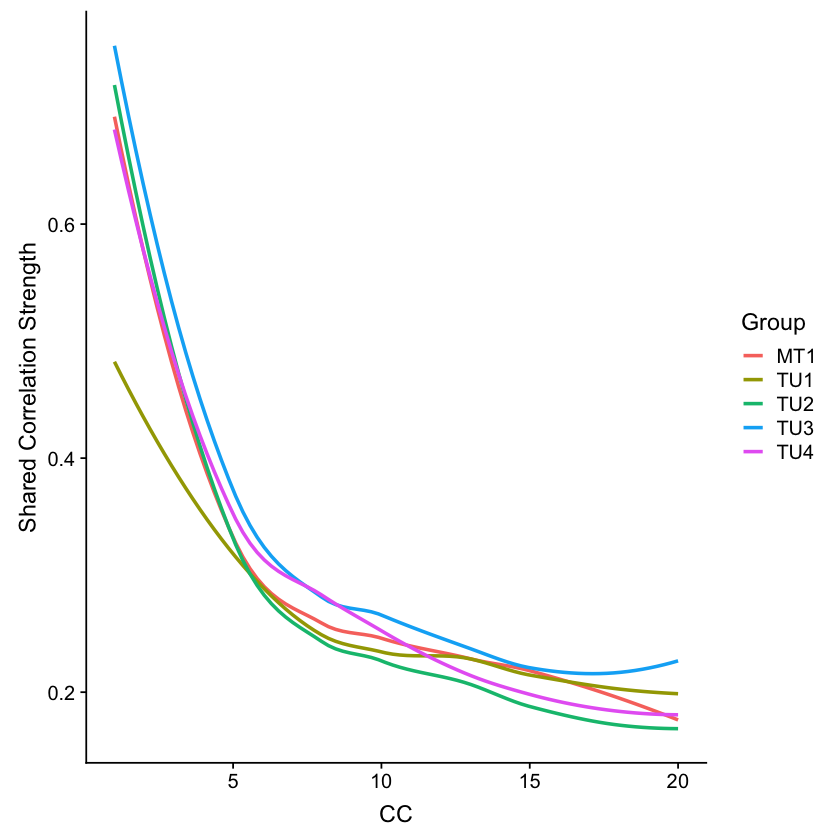

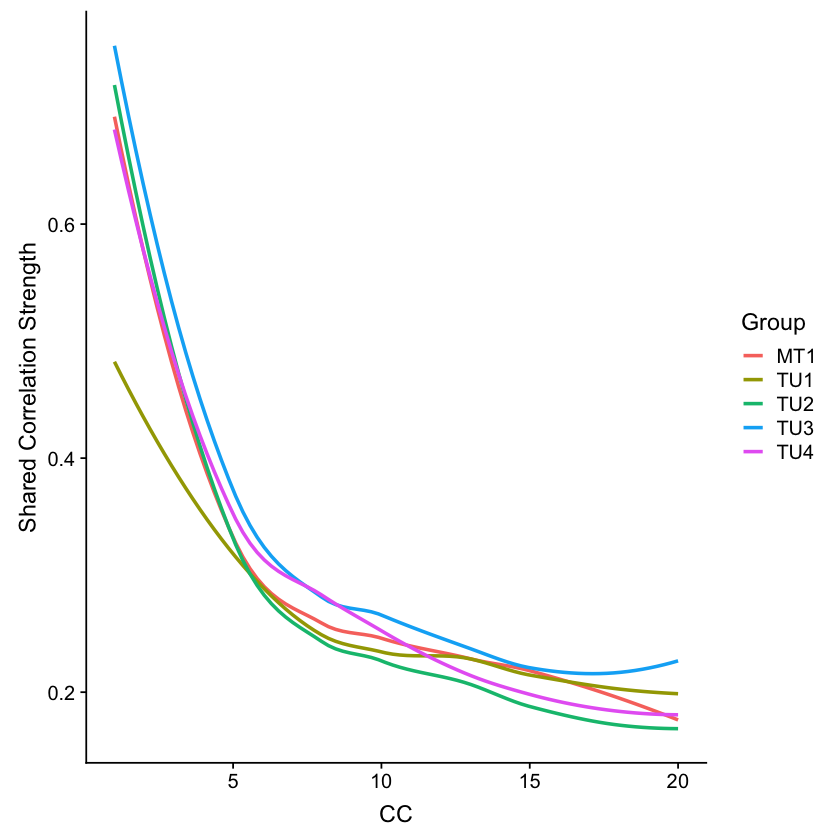

In [14]:
MetageneBicorPlot(cca_out, grouping.var = "group", dims.eval = 1:20, display.progress = FALSE)

The saturation point on these curves provides a valuable guide for the number of CCs to include in our downstream analyses. We decided to go forward with 10 CCs. We also compute the ratio of variance explained by CCA to PCA. This value acts as an indicator of how well each cell is defined by shared sources of variance. A low value indicates non-overlapping cells. A threshold value of 0.5 is used across all the datasets.

In [15]:
cca_out = CalcVarExpRatio(cca_out,reduction.type = "pca", grouping.var = "group", dims.use = 1:10)
cca_out = SubsetData(cca_out, subset.name = "var.ratio.pca",accept.low = 0.5)

Shifts in feature scale or population densities can drive global differences between CC loadings, and must be corrected for as part of the alignment procedure.

In [16]:
cca_out = AlignSubspace(cca_out, reduction.type = "cca", grouping.var = "group", dims.align = 1:10)

Scaling data matrix
Scaling data matrix
Scaling data matrix
Scaling data matrix
Scaling data matrix


In [17]:
CalcAlignmentMetric(cca_out,reduction.use = "cca.aligned",dims.use = 1:10, grouping.var =  "group")

[1] 0.7217662

We now run t-SNE (non-linear dimensionality reduction) followed by clustering.

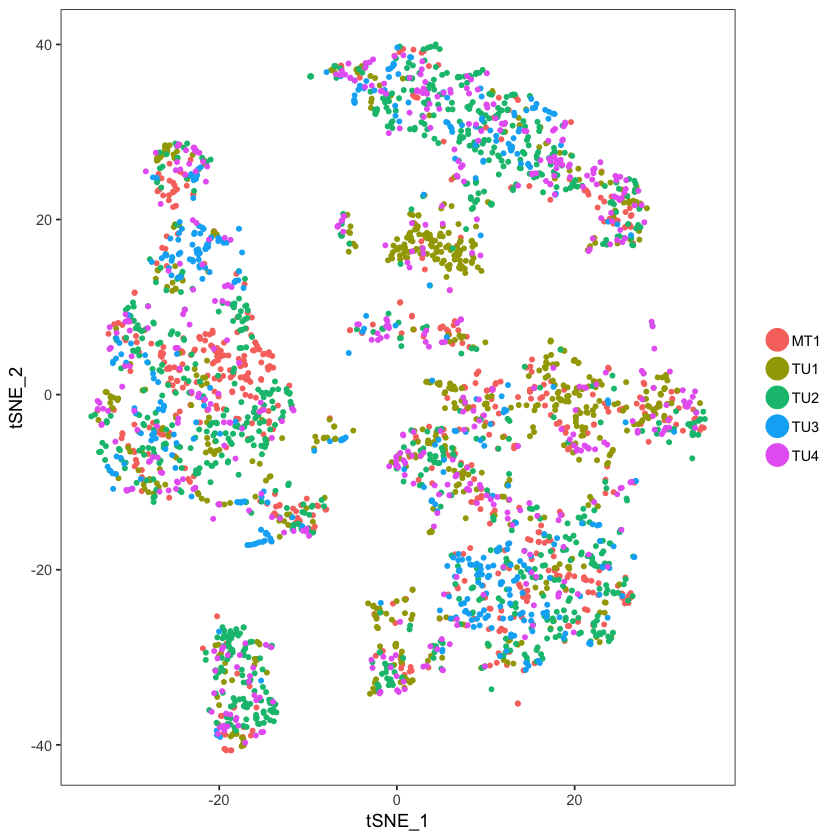

In [19]:
set.seed(1234)
cca_out = RunTSNE(cca_out, reduction.use = "cca.aligned", dims.use = 1:10, do.fast = T)
TSNEPlot(object = cca_out, do.label = F,group.by="group")

In [25]:
cca_out = FindClusters(cca_out, reduction.type = "cca.aligned", resolution = c(0.6), dims.use = 1:10,print.output = F);
table(cca_out@ident)



  0   1   2   3   4   5   6   7   8   9  10 
609 504 487 309 289 221 219 218 100 100  98 

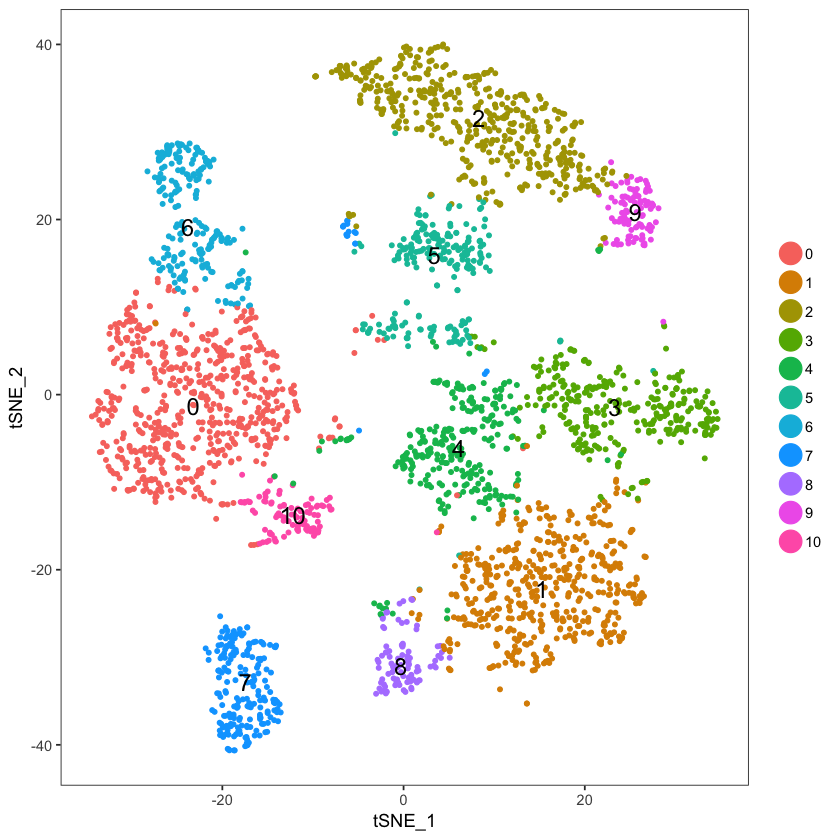

In [26]:
TSNEPlot(object = cca_out, do.label =T,no.legend = FALSE,dark.theme = FALSE,label.size=5)

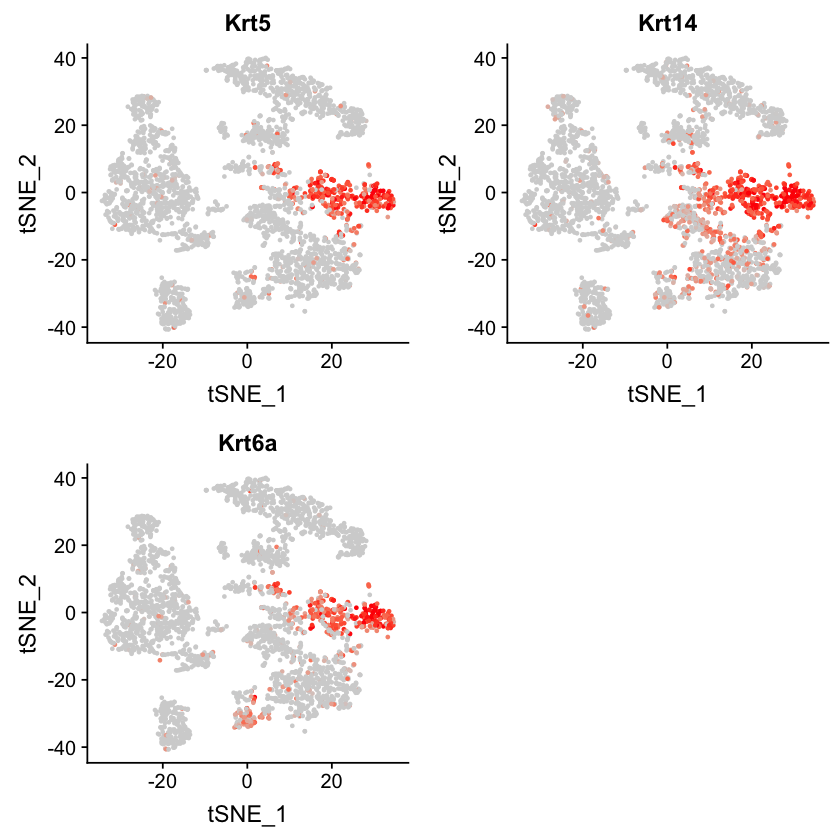

In [27]:
FeaturePlot(cca_out, features.plot = c("Krt5","Krt14","Krt6a"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

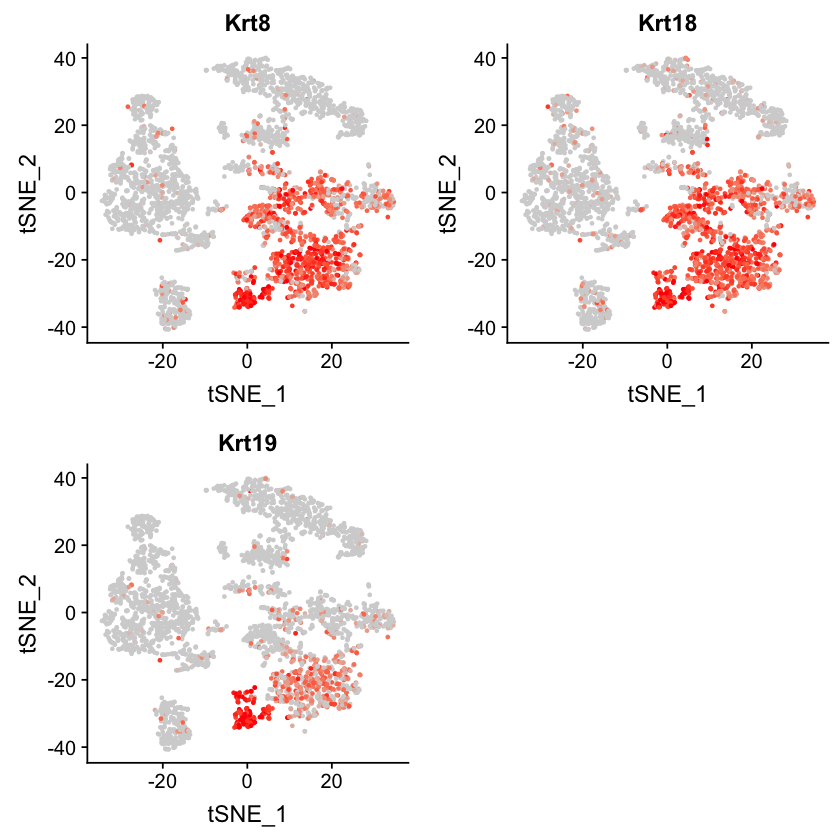

In [28]:
FeaturePlot(cca_out, features.plot = c("Krt8","Krt18","Krt19"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

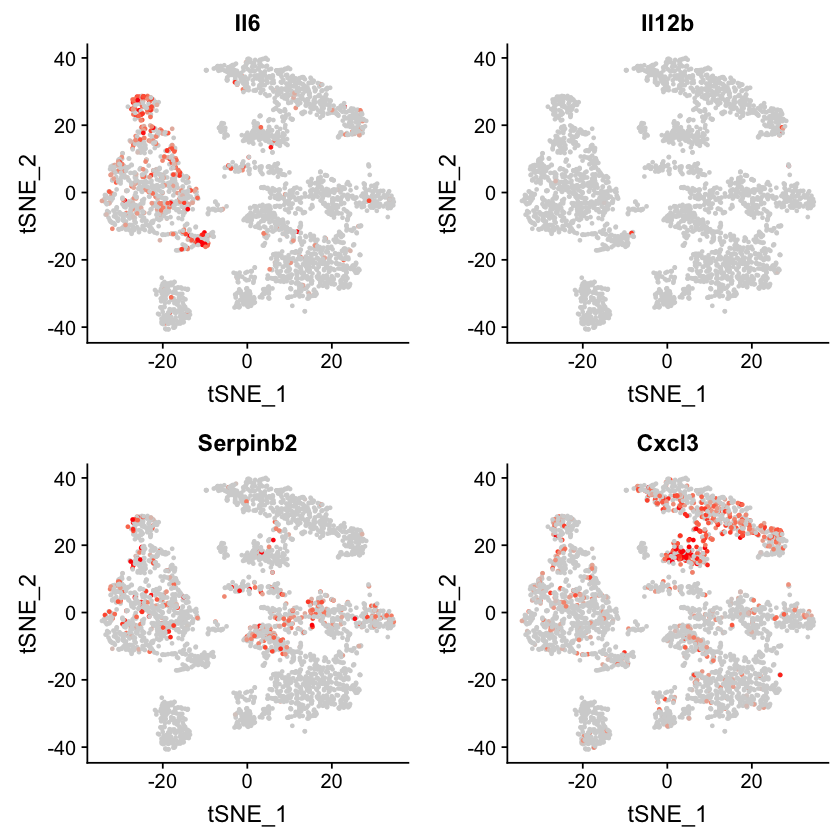

In [29]:
FeaturePlot(cca_out, features.plot = c("Il6","Il12b","Serpinb2","Cxcl3"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

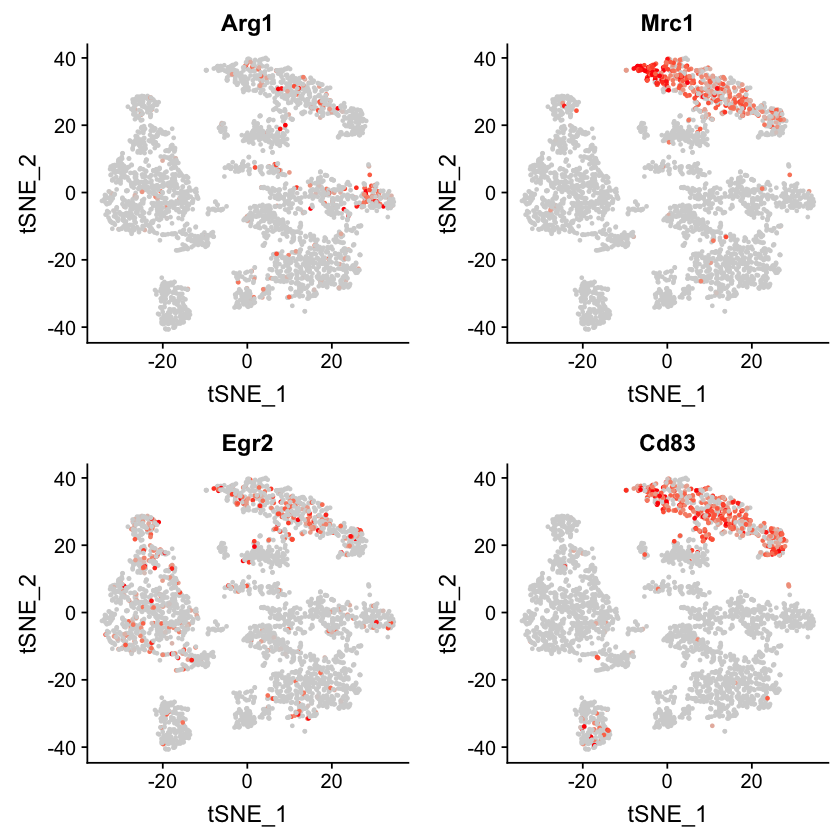

In [30]:
FeaturePlot(cca_out, features.plot = c("Arg1","Mrc1","Egr2","Cd83"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

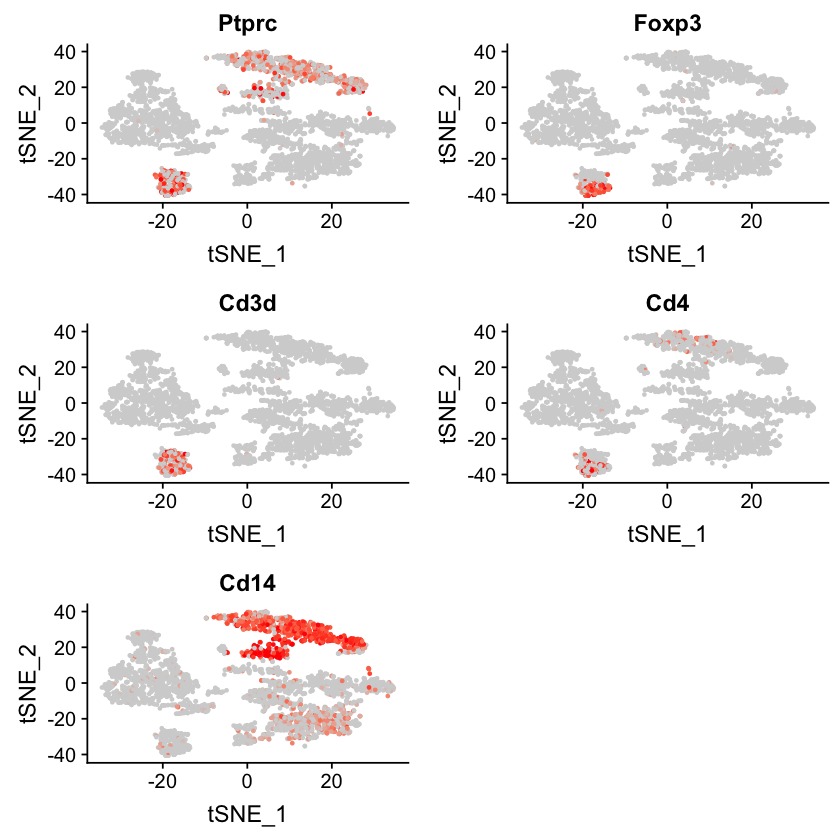

In [31]:
FeaturePlot(cca_out, features.plot = c("Ptprc","Foxp3","Cd3d","Cd4","Cd14"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

We compute single-sample enrichment scores (ssGSEA) using the genesets previously loaded. Each ssGSEA enrichment score represents the degree to which the genes in a particular gene set are coordinately up- or down-regulated within a sample. These genesets encompass immune microenvironment, oncogenic signaling, tumor microenvironment and DNA repair process.

In [32]:
ssgsea_out = gsva(as.matrix(cca_out@data),gset.idx.list=ach$genesets,method="ssgsea",kcdf="Gaussian",min.sz=1,max.sz=1000)

Estimating ssGSEA scores for 49 gene sets.
  |                                                                      |   0%Using parallel with 4 cores
  |======================================================================| 100%


We scale the enrichment scores and display a heatmap.

In [33]:
FM = ssgsea_out
FM = as.matrix(Matrix::t(scale(Matrix::t(FM))))
FM = melt(data.frame(t(FM),"Cluster"=cca_out@ident,"Group"=cca_out@meta.data$group))
colnames(FM)[3:4]=c("GeneSets","EnrichmentScore")
head(FM)

Using Cluster, Group as id variables


Cluster Group GeneSets      EnrichmentScore
1 5       MT1   CP_INHIBITORY -1.0746950     
2 7       MT1   CP_INHIBITORY -0.9288758     
3 7       MT1   CP_INHIBITORY -1.0905170     
4 4       MT1   CP_INHIBITORY -2.1232628     
5 3       MT1   CP_INHIBITORY -1.9220008     
6 4       MT1   CP_INHIBITORY -2.3893126

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session.”

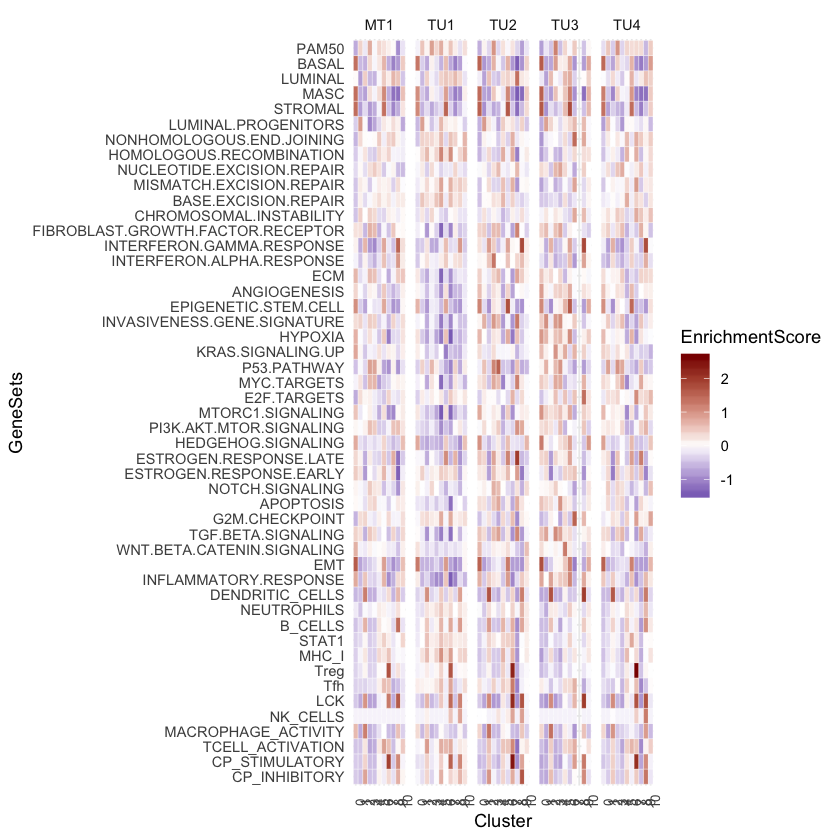

In [34]:
ES_mean = FM %>% dplyr::group_by(Cluster,GeneSets,Group) %>% summarize_all(funs(mean))
ggplot(ES_mean, aes(Cluster, GeneSets)) + geom_tile(aes(fill = EnrichmentScore), colour = "white") + scale_fill_gradient2(low ="dark blue", high ="dark red", mid ="white",space = "Lab") +
      theme_minimal() + theme(axis.text.x=element_text(size=8,angle=90)) + facet_grid(~Group)

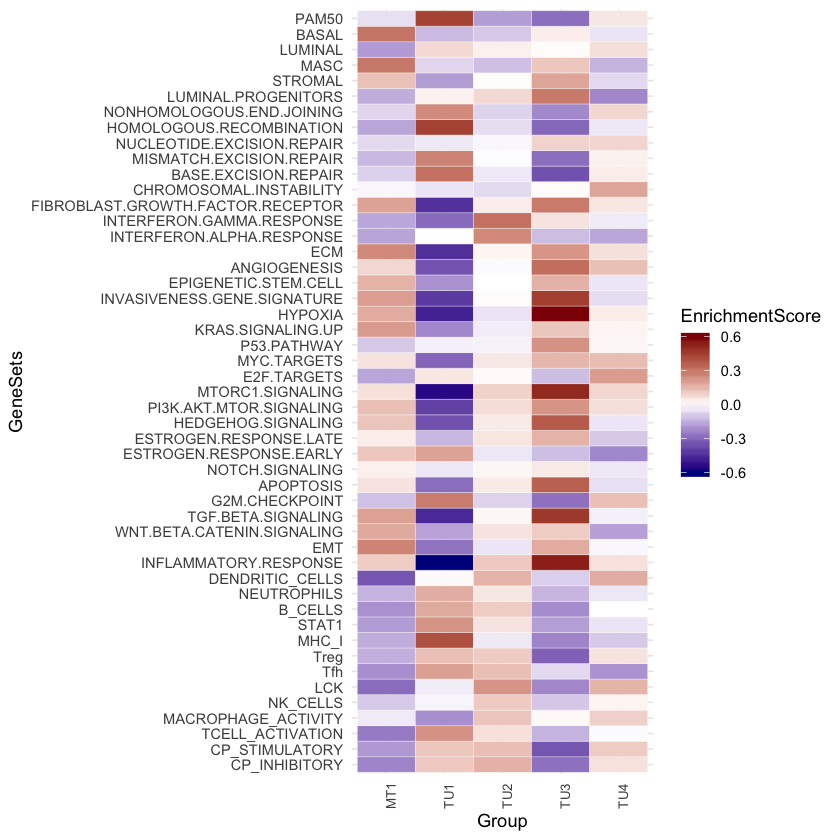

In [35]:
ES1_mean = FM[,-1] %>% dplyr::group_by(GeneSets,Group) %>% summarize_all(funs(mean))
ggplot(ES1_mean, aes(Group, GeneSets)) + geom_tile(aes(fill = EnrichmentScore), colour = "white") + scale_fill_gradient2(low ="dark blue", high ="dark red", mid ="white",space = "Lab") +
      theme_minimal() + theme(axis.text.x=element_text(size=8,angle=90))

We can display feature plots, with gene-sets as features instead of genes.

In [37]:
cca_out@meta.data = cbind(cca_out@meta.data,t(as.matrix(Matrix::t(scale(Matrix::t(ssgsea_out))))))
colnames(cca_out@meta.data)

[1] "nGene"                             "nUMI"                             
 [3] "orig.ident"                        "group"                            
 [5] "var.ratio.pca"                     "res.0.6"                          
 [7] "CP_INHIBITORY"                     "CP_STIMULATORY"                   
 [9] "TCELL_ACTIVATION"                  "MACROPHAGE_ACTIVITY"              
[11] "NK_CELLS"                          "LCK"                              
[13] "Tfh"                               "Treg"                             
[15] "MHC_I"                             "STAT1"                            
[17] "B_CELLS"                           "NEUTROPHILS"                      
[19] "DENDRITIC_CELLS"                   "INFLAMMATORY RESPONSE"            
[21] "EMT"                               "WNT BETA CATENIN SIGNALING"       
[23] "TGF BETA SIGNALING"                "G2M CHECKPOINT"                   
[25] "APOPTOSIS"                         "NOTCH SIGNALING"                  
[27] "ESTROGEN RESPONSE EARLY"           "ESTROGEN RESPONSE LATE"           
[29] "HEDGEHOG SIGNALING"                "PI3K-AKT-MTOR SIGNALING"          
[31] "MTORC1 SIGNALING"                  "E2F TARGETS"                      
[33] "MYC TARGETS"                       "P53 PATHWAY"                      
[35] "KRAS SIGNALING UP"                 "HYPOXIA"                          
[37] "INVASIVENESS GENE SIGNATURE"       "EPIGENETIC STEM CELL"             
[39] "ANGIOGENESIS"                      "ECM"                              
[41] "INTERFERON ALPHA RESPONSE"         "INTERFERON GAMMA RESPONSE"        
[43] "FIBROBLAST GROWTH FACTOR RECEPTOR" "CHROMOSOMAL INSTABILITY"          
[45] "BASE EXCISION REPAIR"              "MISMATCH EXCISION REPAIR"         
[47] "NUCLEOTIDE EXCISION REPAIR"        "HOMOLOGOUS RECOMBINATION"         
[49] "NONHOMOLOGOUS END JOINING"         "LUMINAL PROGENITORS"              
[51] "STROMAL"                           "MASC"                             
[53] "LUMINAL"                           "BASAL"                            
[55] "PAM50"

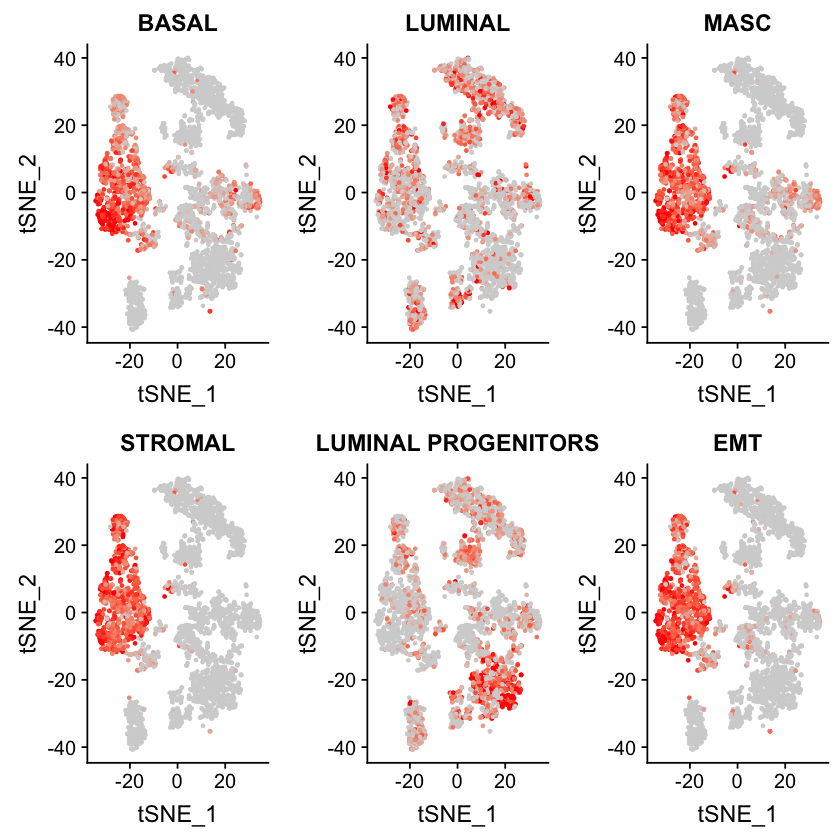

In [38]:
FeaturePlot(cca_out,features.plot=c("BASAL","LUMINAL","MASC","STROMAL","LUMINAL PROGENITORS","EMT"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

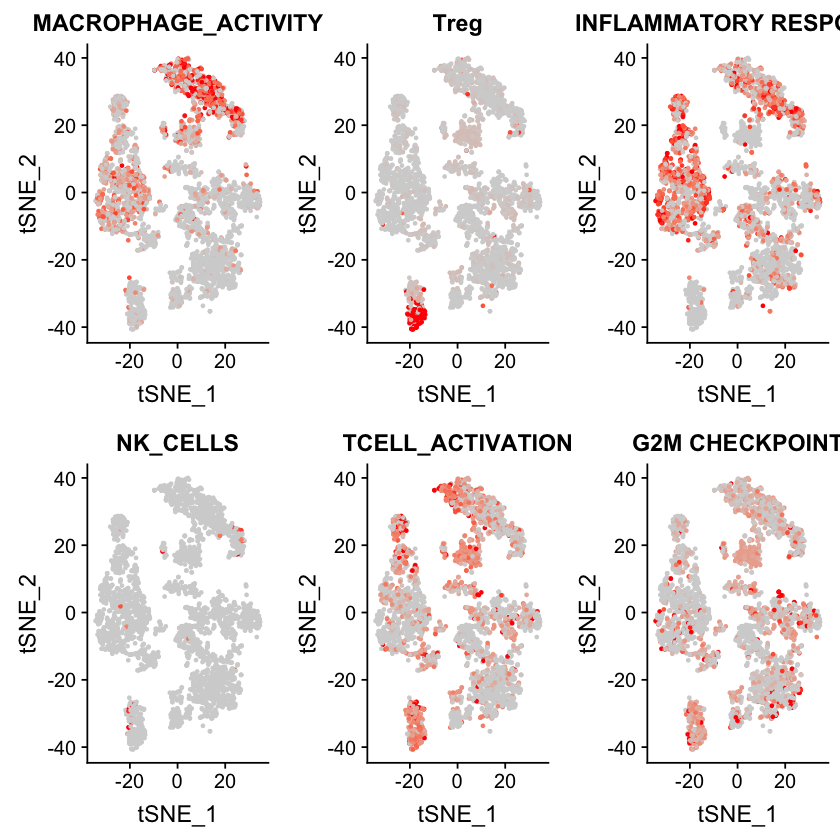

In [39]:
FeaturePlot(cca_out,features.plot=c("MACROPHAGE_ACTIVITY","Treg","INFLAMMATORY RESPONSE","NK_CELLS","TCELL_ACTIVATION","G2M CHECKPOINT"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

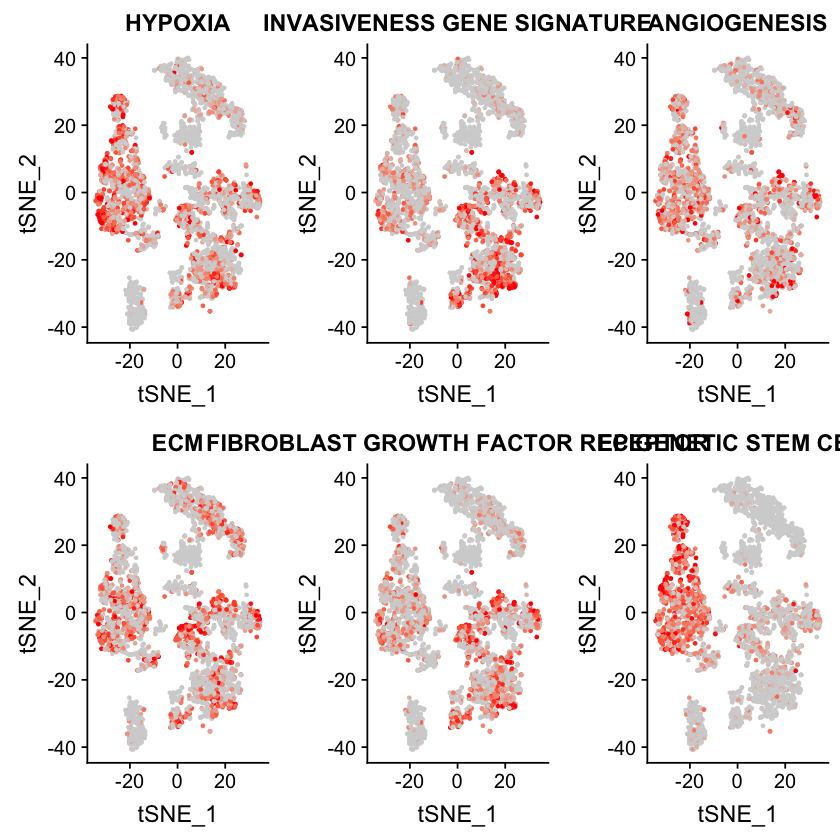

In [40]:
FeaturePlot(cca_out,features.plot=c("HYPOXIA","INVASIVENESS GENE SIGNATURE","ANGIOGENESIS","ECM","FIBROBLAST GROWTH FACTOR RECEPTOR","EPIGENETIC STEM CELL"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

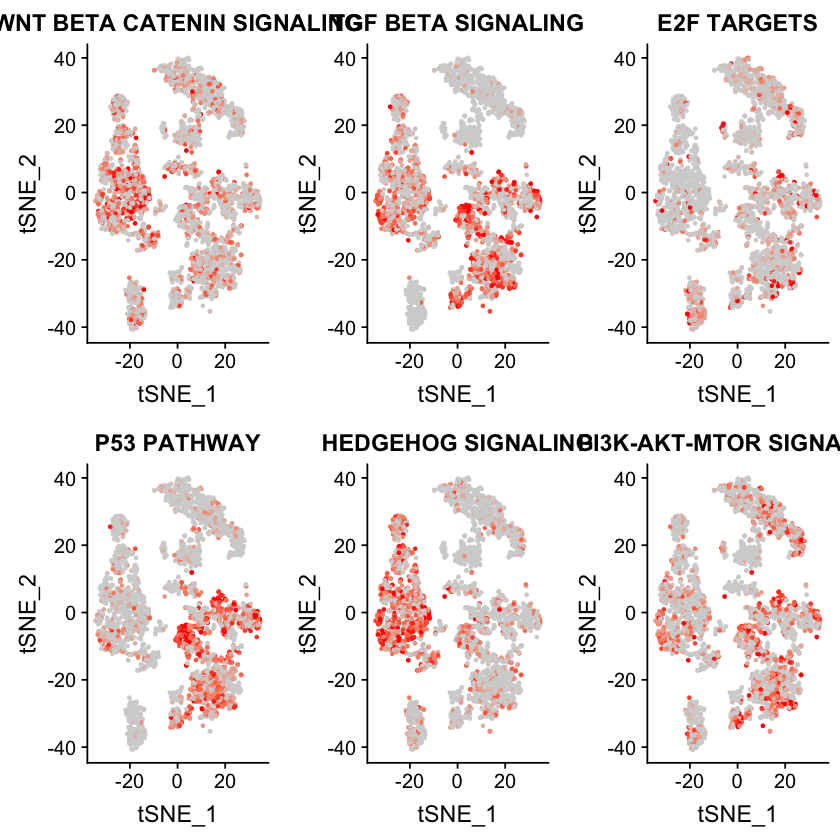

In [41]:
FeaturePlot(cca_out,features.plot=c("WNT BETA CATENIN SIGNALING","TGF BETA SIGNALING","E2F TARGETS","P53 PATHWAY","HEDGEHOG SIGNALING","PI3K-AKT-MTOR SIGNALING"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

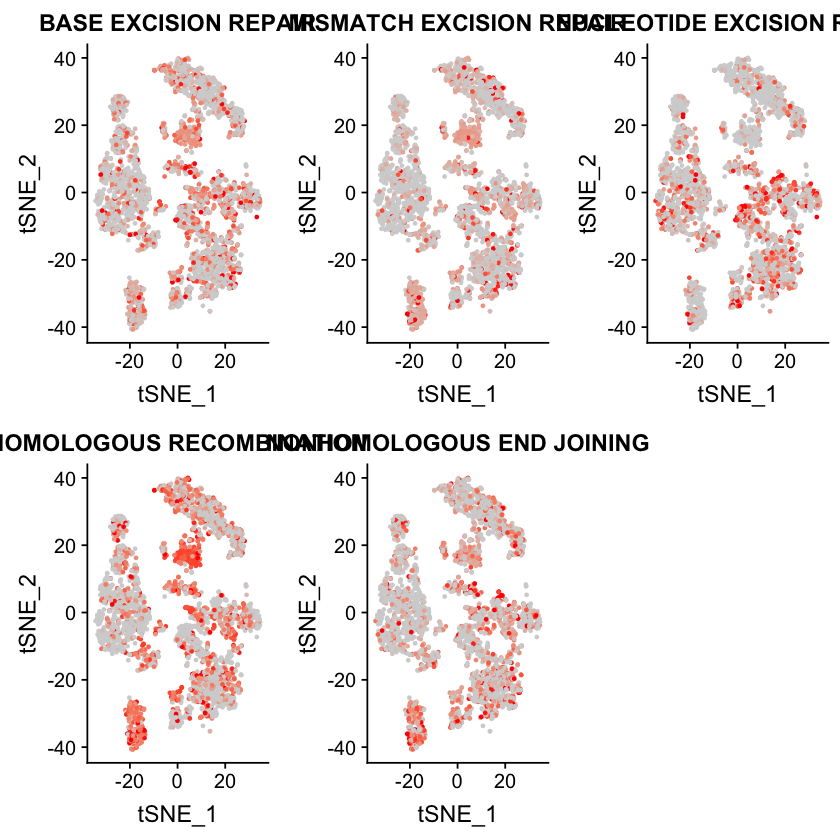

In [42]:
FeaturePlot(cca_out,features.plot=c("BASE EXCISION REPAIR","MISMATCH EXCISION REPAIR","NUCLEOTIDE EXCISION REPAIR","HOMOLOGOUS RECOMBINATION","NONHOMOLOGOUS END JOINING"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)

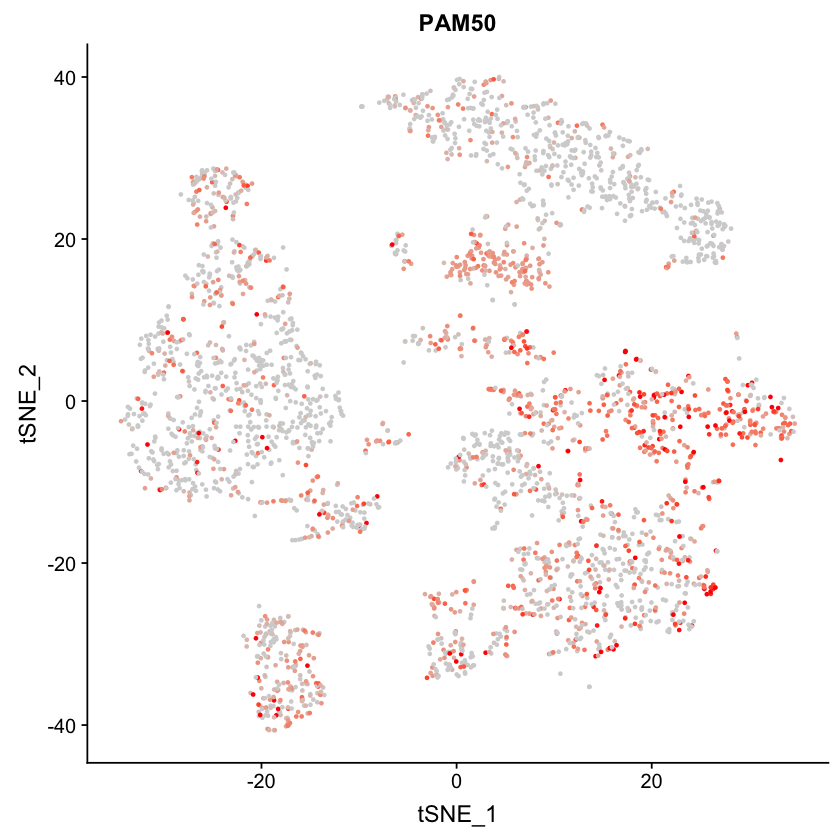

In [43]:
FeaturePlot(cca_out,features.plot=c("PAM50"),reduction.use="tsne",nCol=1,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)


In [44]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] biomaRt_2.38.0    GSVA_1.30.0       data.table_1.12.0 ggthemes_4.1.0   
 [5] dplyr_0.8.0.1     ggpubr_0.2        magrittr_1.5      plyr_1.8.4       
 [9] Seurat_2.3.4      Matrix_1.2-15     cowplot_0.9.4     ggplot2_3.1.0    

loaded via a namespace (and not attached):
  [1] uuid_0.1-2           snow_0.4-3           backports_1.1.3     
  [4] Hmisc_4.2-0          igraph_1.2.4         repr_0.19.2         
  [7] lazyeval_0.2.1       GSEABase_1.44.0      splines_3.5.0       
 [10] diges